In [1]:
import h5py
import xarray as xr
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import mlab
from numba import njit
from numpy.fft import fft, ifft, fftshift, ifftshift
from scipy.constants import c, pi

speed_of_light = c

def plot_signal_components(signal, scale=(None, None), fft_size=128, sample_rate=None, title="", size=(6, 12), times=None, Fc=None):
    if times is None:
        start_time = 0
        end_time = start_time + signal.shape[0]
        t = np.linspace(0, end_time, signal.shape[0])
    else:
        t = times
        sample_rate = signal.shape[0] / (times[-1] - times[0])
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(size[1], size[0]))
    ax1.plot(t, signal.imag, linewidth=0.75, label='Imaginary Part', color="red")
    ax1.plot(t, signal.real, linewidth=0.75, label='Real Part', color="darkblue")
    ax1.set_title(title)
    ax1.set_xlabel("Time (us)")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="lower right")
    ax1.grid(True)
    ax1.set_xlim([t[0], t[-1]])
    ax2.plot(t, np.unwrap(np.angle(signal)), linewidth=0.75, color="red")
    ax2.set_xlabel("Time (us)")
    ax2.set_ylabel("Phase")
    ax2.grid(True)
    ax2.set_xlim([t[0], t[-1]])
    if scale is not None:
        ax3.specgram(signal, NFFT=fft_size, Fs=sample_rate, Fc=Fc, noverlap=fft_size-1, cmap='seismic', vmin=scale[0], vmax=scale[1], window=mlab.window_hanning, aspect='equal')
    else:
        ax3.specgram(signal, NFFT=fft_size, Fs=sample_rate, Fc=Fc, noverlap=fft_size-1, cmap='seismic', aspect='equal')
    ax3.set_xlabel("Time (us)")
    ax3.set_ylabel("Frequency")
    plt.tight_layout()
    plt.subplots_adjust(top=0.75)
    plt.show()

### Reading the Product

In [2]:
nisar_file = '/media/andrew/large/data/NISAR/NISAR_L0_PR_RRSD_008_088_A_156S_20251028T101349_20251028T101443_P05000_F_J_001.h5'

In [3]:
product = h5py.File(nisar_file, 'r')

In [4]:
print(product['science'].keys())
print(product['science']['LSAR'].keys())
print(product['science']['LSAR']['RRSD'].keys())
print(product['science']['LSAR']['RRSD']['metadata'].keys())
print(product['science']['LSAR']['RRSD']['swaths'].keys())
print(product['science']['LSAR']['RRSD']['swaths']['frequencyA'].keys())
print(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH'].keys())
print(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['rxH'].keys())
print(product['science']['LSAR']['identification'].keys())

<KeysViewHDF5 ['LSAR']>
<KeysViewHDF5 ['RRSD', 'identification']>
<KeysViewHDF5 ['highRateTelemetry', 'lowRateTelemetry', 'metadata', 'swaths']>
<KeysViewHDF5 ['processingInformation']>
<KeysViewHDF5 ['frequencyA', 'frequencyB']>
<KeysViewHDF5 ['listOfTxPolarizations', 'txH']>
<KeysViewHDF5 ['UTCtime', 'calType', 'centerFrequency', 'chirpCorrelator', 'chirpDuration', 'chirpSlope', 'chirpWaveform', 'listOfRxPolarizations', 'listOfTxTRMs', 'nominalAcquisitionPRF', 'numberOfSubSwaths', 'radarTime', 'rangeBandwidth', 'rangeLineIndex', 'rxH', 'rxV', 'sceneCenterAlongTrackSpacing', 'sceneCenterGroundRangeSpacing', 'slantRange', 'slantRangeSpacing', 'txPhase', 'validSamplesSubSwath1', 'validSamplesSubSwath2', 'validSamplesSubSwath3', 'validSamplesSubSwath4', 'validSamplesSubSwath5']>
<KeysViewHDF5 ['BFPQLUT', 'HH', 'RD', 'WD', 'WL', 'attenuation', 'basebandPhaseCorrection', 'caltone', 'listOfRxTRMs', 'sampleRateDBF']>
<KeysViewHDF5 ['absoluteOrbitNumber', 'boundingPolygon', 'compositeReleaseI

In [5]:
np.asarray(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['rxH']['WD'])[70000]

array([ 4735,  5530, 28765, 47420,  5755, 25655, 47790, 70135,  8435,
       34800, 61470, 91245], dtype=int32)

In [6]:
np.asarray(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['sceneCenterAlongTrackSpacing'])

array(3.55525009)

In [7]:
bfpqlut = np.asarray(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['rxH']['BFPQLUT'])
data = product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['rxH']['HH'][70000:80000, :]
decoded = bfpqlut[data['r']] + 1j * bfpqlut[data['i']]

In [8]:
data = None
del data

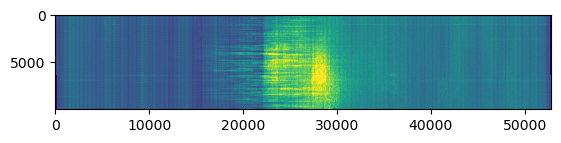

In [9]:
# %matplotlib qt
%matplotlib inline
plt.imshow(np.abs(decoded), vmin=0, vmax=200)
plt.show()

## Range Compression

In [38]:
pulse_length = np.float32(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['chirpDuration'])
ramp_rate = np.float32(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['chirpSlope'])
range_spacing = np.float32(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['slantRangeSpacing'])
sample_rate = c / (2 * range_spacing)
center_freq = np.float32(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['centerFrequency'])
range_bandwidth = np.float32(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['rangeBandwidth'])
slant_ranges = np.float32(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['slantRange'])
wavelength = c / center_freq

In [39]:
chirp = np.asarray(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['chirpWaveform'])
num_az, num_rng = decoded.shape
chirp_len = chirp.size
ref_len = num_rng + 2 * chirp_len
reference_1 = np.zeros(ref_len, dtype=np.complex64)
start = int(np.floor( (ref_len - chirp_len) / 2))
end = start + chirp_len
reference_1[start:end] = chirp

reference_1 = fft(reference_1)
reference_1 *= (1 / chirp_len) * np.sqrt(range_bandwidth / sample_rate)

In [40]:
decoded = np.pad(decoded, ((0, 0), (0, 2 * chirp_len)))

In [50]:
rc_subset = ifftshift(ifft(fft(decoded) * np.conj(reference_1), axis=1)[:, chirp_len:num_rng+chirp_len], 1)

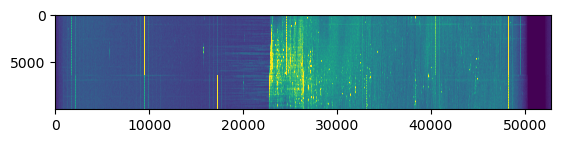

In [51]:
# %matplotlib qt
%matplotlib inline
plt.imshow(np.abs(rc_subset), vmin=0, vmax=4)
plt.show()

/home/andrew/miniforge3/envs/signal_processing/lib/python3.12/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


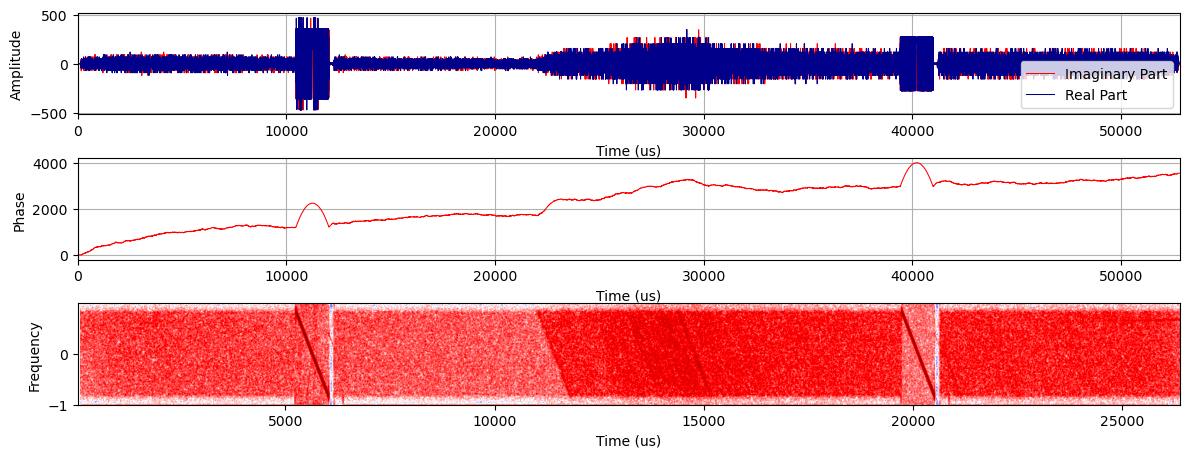

In [52]:
plot_signal_components(decoded[9205, :num_rng])

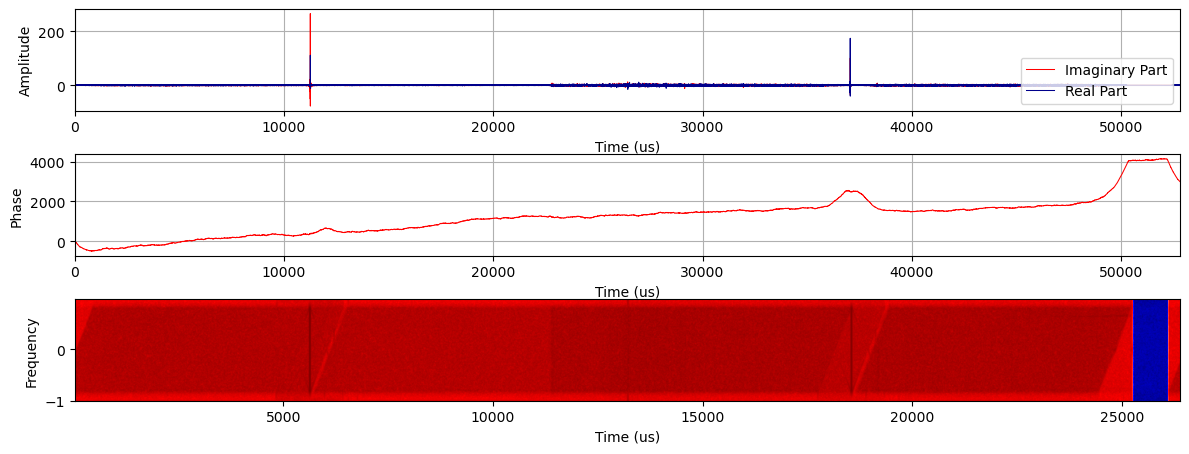

In [53]:
plot_signal_components(rc_subset[9205, :num_rng])

## Orbit Information

In [11]:
quaternions = np.asarray(product['science']['LSAR']['RRSD']['lowRateTelemetry']['attitude']['quaternions'])
q_times = np.asarray(product['science']['LSAR']['RRSD']['lowRateTelemetry']['attitude']['time'])

In [12]:
positions = np.asarray(product['science']['LSAR']['RRSD']['lowRateTelemetry']['orbit']['position'])
velocities = np.asarray(product['science']['LSAR']['RRSD']['lowRateTelemetry']['orbit']['velocity'])
times = np.asarray(product['science']['LSAR']['RRSD']['lowRateTelemetry']['orbit']['time'])

In [14]:
# uniform_prf = 1520
# az_times = np.linspace(-uniform_prf / 2, uniform_prf / 2, num_az)

## Forward Mapping Algorithm

#### Retrieve the DEM

In [16]:
from hyp3lib.dem import prepare_dem_geotiff
from shapely import wkt
from osgeo import ogr, osr
from pathlib import Path

In [17]:
epsg_code = 4326

bbox = np.asarray(product['science']['LSAR']['identification']['boundingPolygon'])[np.newaxis][0]
bbox = wkt.loads(bbox)
geom = ogr.CreateGeometryFromWkt(str(bbox))

srs = osr.SpatialReference()
srs.ImportFromEPSG(epsg_code)
geom.AssignSpatialReference(srs)

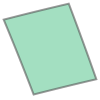

In [18]:
bbox

In [19]:
dem_path = 'dem.tif'
if not Path(dem_path).exists():
    dem_path = prepare_dem_geotiff(
        output_name='dem.tif',
        geometry=geom,
        epsg_code=epsg_code,
        pixel_size=0.001,
        height_above_ellipsoid=True
    )

#### Get DEM Interpolator

In [20]:
from osgeo import gdal

gdal.UseExceptions()

ds = gdal.Open(dem_path)
trans = ds.GetGeoTransform()  # In EPSG:4326
band = ds.GetRasterBand(1)
dem = band.ReadAsArray()

min_lon = trans[0]
max_lat = trans[3]
lon_res = trans[1]
lat_res = trans[5]

num_lats, num_lons = dem.shape

dem_lons = np.linspace(min_lon, min_lon + lon_res * num_lons, num_lons)
dem_lats = np.linspace(max_lat + lat_res * num_lats, max_lat, num_lats)

dem_interp = sp.interpolate.RegularGridInterpolator((dem_lats, dem_lons), dem, bounds_error=False, fill_value=np.nan, method='cubic')

In [21]:
# Courtesy of CHATGPT - Because RegularGridInterpolator is slow
import numpy as np
try:
    from numba import njit
except Exception:
    def njit(*a, **k):
        def wrap(f): return f
        return wrap

# === Cubic kernel helpers (Numba-safe) ===

@njit(cache=True, fastmath=True)
def _cubic_weight(t, a):
    at = abs(t)
    if at < 1.0:
        return (a + 2.0)*at*at*at - (a + 3.0)*at*at + 1.0
    elif at < 2.0:
        return a*at*at*at - 5.0*a*at*at + 8.0*a*at - 4.0*a
    else:
        return 0.0

@njit(cache=True, fastmath=True)
def _weights4(frac, a, w):
    # weights for offsets -1,0,1,2 given fractional part in [0,1]
    w[0] = _cubic_weight(1.0 + (1.0 - frac), a)  # t = -1 - frac
    w[1] = _cubic_weight(1.0 - frac, a)          # t = -frac
    w[2] = _cubic_weight(frac, a)                # t = +frac
    w[3] = _cubic_weight(1.0 + frac, a)          # t = 1 + frac

@njit(cache=True)
def _find_interval(coords, q):
    n = coords.size
    if q <= coords[0]:
        return 0, 0.0
    if q >= coords[n-1]:
        return n-2, 1.0
    j = np.searchsorted(coords, q, side='right') - 1
    d = coords[j+1] - coords[j]
    frac = 0.0 if d == 0.0 else (q - coords[j]) / d
    return j, frac

@njit(cache=True)
def _clamp(i, lo, hi):
    if i < lo: return lo
    if i > hi: return hi
    return i

# edge_mode: 0 = clamp, 1 = fill
@njit(cache=True, fastmath=True)
def _bicubic_sample_one(z, x, y, xq, yq, a, edge_mode, fill_value):
    ny, nx = z.shape

    if edge_mode == 1:
        if (xq < x[0]) or (xq > x[nx-1]) or (yq < y[0]) or (yq > y[ny-1]):
            return fill_value, False

    ix, fx = _find_interval(x, xq)
    iy, fy = _find_interval(y, yq)

    ix0 = ix - 1
    iy0 = iy - 1

    wx = np.empty(4, np.float64)
    wy = np.empty(4, np.float64)
    _weights4(fx, a, wx)
    _weights4(fy, a, wy)

    acc = 0.0
    for m in range(4):
        yy = iy0 + m
        if yy < 0: yy = 0
        elif yy >= ny: yy = ny - 1
        row_sum = 0.0
        for n in range(4):
            xx = ix0 + n
            if xx < 0: xx = 0
            elif xx >= nx: xx = nx - 1
            row_sum += wx[n] * z[yy, xx]
        acc += wy[m] * row_sum

    return acc, True

# === Numba-callable vector evaluator: points shape (N, 2) ===
@njit(cache=True, fastmath=True)
def bicubic_interpolate_points(z, x, y, points, a=-0.5, edge_mode=0, fill_value=np.nan):
    """
    z: (ny, nx), x: (nx,), y: (ny,), points: (N,2)->(x_i, y_i)
    edge_mode: 0='clamp', 1='fill'
    Returns vals: (N,)
    """
    n = points.shape[0]
    out = np.empty(n, dtype=np.float64)
    for i in range(n):
        v, ok = _bicubic_sample_one(z, x, y, points[i, 0], points[i, 1],
                                    a, edge_mode, fill_value)
        out[i] = v if ok else fill_value
    return out

# === Python-friendly wrapper that looks like SciPy's RGI ===
class RegularGridBicubic:
    def __init__(self, x, y, z, a=-0.5, bounds_error=False, fill_value=np.nan, edge_mode="clamp"):
        """
        x: (nx,), y: (ny,), z: (ny, nx)
        edge_mode: 'clamp' (default) or 'fill'
        If bounds_error=True, raise on out-of-bounds instead of filling/clamping.
        """
        x = np.asarray(x, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        z = np.asarray(z, dtype=np.float64)
        if not (np.all(np.diff(x) > 0) and np.all(np.diff(y) > 0)):
            raise ValueError("x and y must be strictly increasing.")
        if z.shape != (y.size, x.size):
            raise ValueError("z must have shape (len(y), len(x)).")

        self.x = x
        self.y = y
        self.z = z
        self.a = float(a)
        self.fill_value = float(fill_value)
        self.bounds_error = bool(bounds_error)
        self.edge_mode = 0 if edge_mode == "clamp" else 1

    def __call__(self, points):
        """
        points:
          - shape (N,2) -> returns (N,)
          - shape (2,N) -> returns (N,)
          - shape (2,)  -> returns scalar
        """
        pts = np.asarray(points, dtype=np.float64)
        scalar = False

        if pts.ndim == 1 and pts.size == 2:
            pts = pts.reshape(1, 2)
            scalar = True
        elif pts.ndim == 2 and pts.shape[0] == 2 and pts.shape[1] != 2:
            pts = pts.T  # (2,N) -> (N,2)
        elif pts.ndim != 2 or pts.shape[1] != 2:
            raise ValueError("points must be (N,2), (2,N), or (2,)")

        if self.bounds_error:
            if (np.any(pts[:, 0] < self.x[0]) or np.any(pts[:, 0] > self.x[-1]) or
                np.any(pts[:, 1] < self.y[0]) or np.any(pts[:, 1] > self.y[-1])):
                raise ValueError("One or more points are out of bounds.")

        vals = bicubic_interpolate_points(
            self.z, self.x, self.y, pts,
            a=self.a,
            edge_mode=self.edge_mode,
            fill_value=self.fill_value
        )
        return vals[0] if scalar else vals

def make_bicubic_interpolator(x, y, z, *, a=-0.5, bounds_error=False, fill_value=np.nan, edge_mode="clamp"):
    """
    Factory matching SciPy's RegularGridInterpolator ergonomics.
    Returns a callable interpolator object.
    """
    return RegularGridBicubic(x, y, z, a=a, bounds_error=bounds_error,
                              fill_value=fill_value, edge_mode=edge_mode)

In [22]:
interp = make_bicubic_interpolator(dem_lons, dem_lats, dem, a=-0.5, edge_mode="clamp")

#### Convert from ECEF Coordinates to Geodetic Coordinates (Latitude, Longitude)

In [23]:
@njit
def ecef_to_latlon(X, Y, Z):
    lon = np.arctan2(Y, X) * 360 / (2 * pi)

    # Latitude and Height is where Newton-Raphson comes into play
    # See https://en.wikipedia.org/wiki/Geographic_coordinate_conversion#From_ECEF_to_geodetic_coordinates
    a = 6378137 # WGS84 Semi-major axis
    b = 6356752.31424518 # WGS84 Semi-minor axis
    e = 0.081819190842622 # WGS84 Eccentricity

    # Instead of doing iterations, we can apply Ferrari's solution
    ep2 = (a**2 - b**2) / b**2
    p = np.sqrt(X**2 + Y**2)
    F = 54 * b**2 * Z**2
    G = p**2 + (1 - e**2) * Z**2 - e**2 * (a**2 - b**2)
    c_ = (e**4 * F * p**2) / G**3
    s = np.power(1 + c_ + np.sqrt(c_**2 + 2 * c_), 1/3)
    k = s + 1 + (1 / s)
    P = F / (2 * k**2 * G**2)
    Q = np.sqrt(1 + 2 * e**4 * P)
    r_0 = (-P * e**2 * p) / (1 + Q)
    r_0 += np.sqrt((0.5 * a**2) * (1 + (1 / Q)) - ((P * (1 - e**2) * Z**2) / (Q * (1 + Q))) - (0.5 * P * p**2))
    U = np.sqrt((p - e**2 * r_0)**2 + Z**2)
    V_ = np.sqrt( (p - e**2 * r_0)**2 + (1 - e**2) * Z**2)
    z_0 = b**2 * Z / (a * V_)
    h = U * (1 - (b**2 / (a * V_)))
    lat = (np.arctan((Z + ep2*z_0) / p) * 360) / (2 * pi)

    return lat, lon, h


@njit
def get_radius_at_latitude(lat):
    # https://gscommunitycodes.usf.edu/geoscicommunitycodes/public/geophysics/Gravity/earth_shape.php
    flattening = 1/298.257223563
    a = 6378137
    return a * (1 - flattening * np.sin(lat)**2)


@njit
def get_range_doppler_coefs(R_sat, R_0, R_geo, h_0, f_d, V, v, L, t, m, n):
    gamma = R_sat / R_0
    gamma += R_0 / R_sat
    gamma -= ((h_0 + R_geo) / R_sat) * ((h_0 + R_geo) / R_0)
    gamma *= R_0 / 2

    alpha = f_d * wavelength * R_0 / (2 * np.linalg.norm(V))
    alpha -= gamma * np.dot(n, v)
    alpha /= np.dot(t, v)

    beta = -L * np.sqrt(R_0**2 - gamma**2 - alpha**2)

    return alpha, beta, gamma


@njit
def get_tcn_coordinate_system(P, V, R_sat, R_geo):
    v = V / np.linalg.norm(V)
    n = -P / np.linalg.norm(P)
    m = np.cross(n, V) / np.linalg.norm(np.cross(n, V)) # m replaces c in the spec
    t = np.cross(m, n)
    return t, m, n, v

#### Setup Satellite TCN (tangent, cross-track, nadir) Coordinate System and Iteratively Solve the Range Doppler Equation

$T = R_{sat} + \alpha.t + \beta.m + \gamma.n$

In [24]:
def radar_to_map_coords(start_az_index, end_az_index, slant_ranges, packet_times, dem_interp, position_interp, velocity_interp, threshold=5e-2, max_iters=25):
    """Get Radar to Map Grid"""

    num_az = end_az_index - start_az_index
    num_rng = slant_ranges.size

    grid = np.zeros((num_az, num_rng, 5))

    for az_index in range(start_az_index, end_az_index):
        # Setup TCN (Tangent, Cross-track, Nadir) Coordinate System
        t0 = packet_times[az_index]

        P = pos_interp(t0)
        V = vel_interp(t0)

        sat_lat, sat_lon, sat_alt = ecef_to_latlon(P[0], P[1], P[2]) 

        R_geo = get_radius_at_latitude(sat_lat)
        R_sat = np.linalg.norm(P)

        t, m, n, v = get_tcn_coordinate_system(P, V, R_sat, R_geo)

        f_d = 0.0 # Assumes Zero-Doppler Geometry

        # Left looking = 1
        # Right looking = -1
        L = 1.0

        for rng_index in range(num_rng):
            R_0 = slant_ranges[rng_index]
            h_0 = 0.0
            h_from_dem = -500.0
            T = np.zeros((3,), dtype=np.float64)
            inc = 0.0
            iters = 0
            while np.abs(h_from_dem - h_0) > threshold and iters < max_iters:
                h_0 = h_from_dem

                # Solve the Range Doppler Equation
                alpha, beta, gamma = get_range_doppler_coefs(R_sat, R_0, R_geo, h_0, f_d, V, v, L, t, m, n)

                T = P + alpha * t + beta * m + gamma * n

                # Update height estimate for the next iteration
                X, Y, Z = T
                lat, lon, _ = ecef_to_latlon(X, Y, Z)
                h_from_dem = dem_interp([lat, lon])

                # Save incidence angle for later
                inc = np.dot(P, T) / (np.linalg.norm(P) * np.linalg.norm(T))

                iters += 1

            if iters >= max_iters - 1:
                print(f'Reached Maximum Number of Iterations for {az_index}, {rng_index}.')

            grid[az_index - start_az_index, rng_index] = X, Y, Z, h_from_dem, inc

    return grid

In [63]:
import time

pos_interp = sp.interpolate.interp1d(times, positions, axis=0)
vel_interp = sp.interpolate.interp1d(times, velocities, axis=0)
packet_times = np.asarray(product['science']['LSAR']['RRSD']['swaths']['frequencyA']['txH']['UTCtime'])

start_az_index = 75000
end_az_index = 80000

start_time = time.time()
grid = radar_to_map_coords(start_az_index, end_az_index, slant_ranges, packet_times, interp, pos_interp, vel_interp, max_iters=25)
end_time = time.time()

print(f'rdr2geo to {end_time-start_time}s for {end_az_index-start_az_index} azimuth lines.')

rdr2geo to 3906.529547691345s for 5000 azimuth lines.


In [64]:
np.save(f'/media/andrew/large/nisar_grid_{start_az_index}_{end_az_index}.npy', grid)

## Delay Model

In [31]:
@njit
def get_tropo_delay(height, incidence_angle):
    D_0 = 2.3 # meters
    H = 6000  # meters
    return (2 / speed_of_light) * (D_0 / np.cos(incidence_angle)) * np.exp(-height / H)

@njit
def get_total_delay(T_ij, p_k, v_k):
    x_ij = T_ij[:3]
    h_ij = T_ij[3]
    inc = T_ij[4]
    p_ijk = np.abs(x_ij - p_k)

    t_atm = get_tropo_delay(h_ij, inc)
    t_ijk = t_atm + (2 * p_ijk + 2 * (x_ij - p_k) * (v_k / speed_of_light)) / (speed_of_light * (1 - (v_k**2 / speed_of_light**2)))

    return t_ijk

In [32]:
def get_delays(start_az_index, end_az_index, grid, packet_times, position_interp, velocity_interp):
    """Get Delay `t_ijk`"""

    num_az = end_az_index - start_az_index
    num_rng = slant_ranges.size

    delays = np.zeros((num_az, num_rng, 3), dtype=np.float64)

    for az_index in range(start_az_index, end_az_index):

        # Retrieve TCN (Tangent, Cross-track, Nadir) Coordinate System
        t0 = packet_times[az_index]
        p_k = pos_interp(t0)
        v_k = vel_interp(t0)
        T = grid[az_index - start_az_index]

        for rng_index in range(num_rng):
            delays[az_index - start_az_index, rng_index] = get_total_delay(T[rng_index], p_k, v_k)

    return delays

In [33]:
start_time = time.time()
delays = get_delays(start_az_index, end_az_index, grid, packet_times, pos_interp, vel_interp)
end_time = time.time()

print(f'Delay calculations took {end_time-start_time}s')

Delay calculations took 194.28003692626953s


## Back Projection

#### Range Interpolation

In [36]:
@njit
def knab_kernel(t, L, v):
    if t == 0.0:
        return 1.0

    phi = np.sin(pi * t) / (pi * t)
    cosh_inner = (pi * v * L / 2) * np.sqrt(1 - (2 * t / L)**2)
    phi *= np.cosh(cosh_inner) / np.cosh(pi * v * L / 2)

    return phi

@njit
def interpolate_signals_to_grid(radar_data, delays, slant_ranges, range_bandwidth):
    num_az, num_rng = radar_data.shape
    kernel_offset = 9
    L = 2 * kernel_offset + 1
    kernel_bandwidth = L / num_rng
    round_trip_delays = (2 * slant_ranges / speed_of_light)

    interpolated_radar_data = np.zeros((num_az, num_rng), dtype=np.complex64)

    swst = round_trip_delays[0]
    swl = round_trip_delays[-1] - swst

    for az_index in range(num_az):
        for rng_index in range(num_rng):
            t_ijk = np.linalg.norm(delays[az_index, rng_index])
            n_0 = rng_index
            start_rng = n_0 - kernel_offset if n_0 - kernel_offset >= 0 else 0
            end_rng = n_0 + kernel_offset if n_0 + kernel_offset < num_rng else num_rng - 1

            signal_chip = radar_data[az_index][start_rng:end_rng]
            current_time = (rng_index / num_rng) * swl
            knabbed_delay = knab_kernel(current_time - (t_ijk - swst), L, kernel_bandwidth)
            interpolated_radar_data[az_index][rng_index] = np.sum(knabbed_delay * signal_chip)

    return interpolated_radar_data

In [54]:
start_time = time.time()
interped_signals = interpolate_signals_to_grid(rc_subset[:5000], delays, slant_ranges, range_bandwidth)
end_time = time.time()

print(f'Range interpolation took {end_time-start_time}s')

Range interpolation took 24.635446786880493s


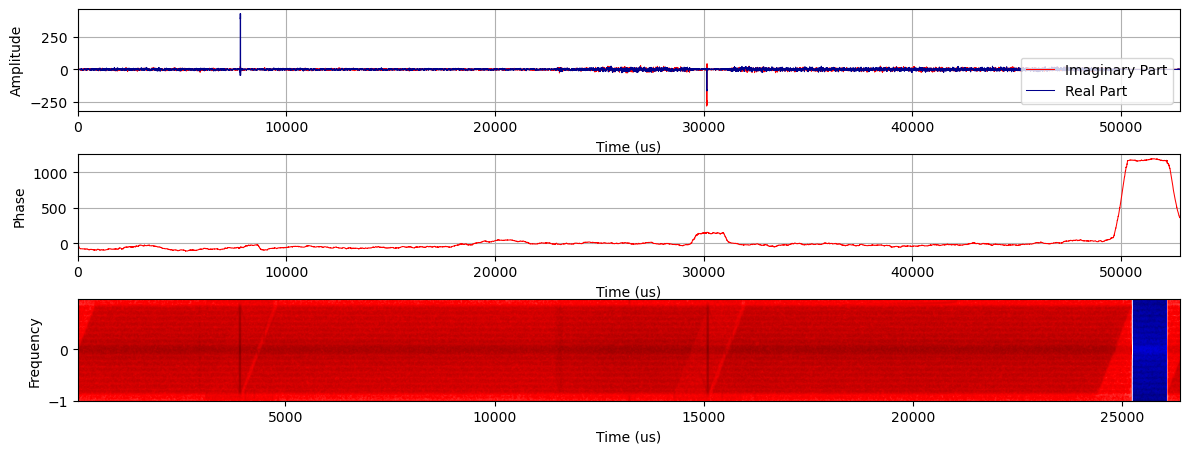

In [55]:
plot_signal_components(interped_signals[0])

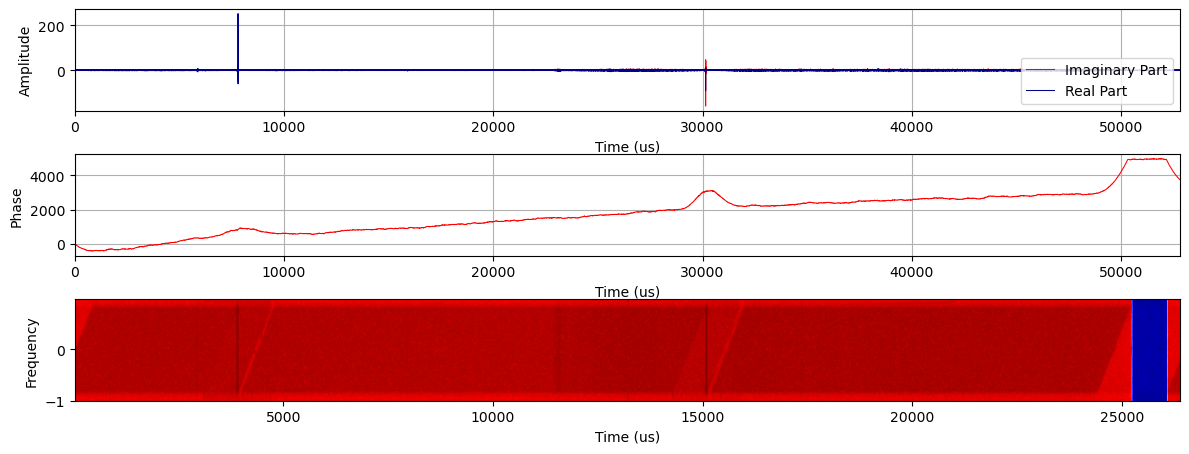

In [56]:
plot_signal_components(rc_subset[0])

In [57]:
@njit
def back_project(radar_data, delays, center_freq):
    num_az, num_rng = radar_data.shape

    # FIXME: Replace this with the proper calculation
    N = 500

    focused_data = np.zeros((num_az, num_rng), dtype=np.complex64)

    for az_index in range(num_az):
        for rng_index in range(num_rng):
            start_az = az_index - int(np.floor(0.5*N)) if az_index - 0.5*N >= 0 else 0
            end_az = az_index + int(np.floor(0.5*N)) if az_index + 0.5*N < num_az else num_az - 1

            t_ijk = delays[start_az:end_az, rng_index]
            x_ijk = radar_data[start_az:end_az, rng_index]

            phase_product = np.exp(2j * pi * center_freq * t_ijk) * x_ijk
            focused_data[az_index, rng_index] = np.sum(phase_product)

    return focused_data

In [58]:
normalized_delays = np.linalg.norm(delays, axis=2)

In [59]:
start_time = time.time()
focused = back_project(interped_signals, normalized_delays, center_freq)
end_time = time.time()

print(f'Azimuth focusing took {end_time-start_time}s')

Azimuth focusing took 1401.5591413974762s


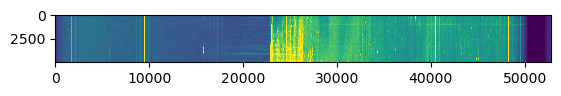

In [60]:
# %matplotlib qt
%matplotlib inline
plt.imshow(np.abs(rc_subset[:end_az_index-start_az_index, :]), vmin=0, vmax=3)
plt.show()

In [62]:
%matplotlib qt
# %matplotlib inline
plt.imshow(np.abs(focused[:, :]), vmin=0, vmax=90)
plt.show()